In [1]:
%env CUDA_VISIBLE_DEVICES=7
%env TOKENIZERS_PARALLELISM=false
%env WANDB_NOTEBOOK_NAME=quant.ipynb

import random

import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor

from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig

from datasets import load_dataset

from tqdm.notebook import tqdm, trange

env: CUDA_VISIBLE_DEVICES=7
env: TOKENIZERS_PARALLELISM=false
env: WANDB_NOTEBOOK_NAME=quant.ipynb


In [2]:
DEVICE = "cuda"

In [3]:
import sys
sys.path.append("./gptq")
from edenn import edenn


NUM_SAMPLES = 2**15

In [4]:
QUIP_SHARP_MEANS = {}

### QuIP#

In [5]:
from e8p2 import QUIP_SHARP_QUANTIZER_2

In [6]:
with torch.no_grad():
    x = torch.empty((NUM_SAMPLES, 8), device=DEVICE).normal_()
    dequant = QUIP_SHARP_QUANTIZER_2.quantize(x, return_idx=False)
    QUIP_SHARP_MEANS[2] = (x - dequant).pow(2).mean().item()

In [7]:
# from e8p3 import QUIP_SHARP_QUANTIZER_3

In [8]:
# with torch.no_grad():
#     x = torch.empty((NUM_SAMPLES, 8), device=DEVICE).normal_()
#     dequant = QUIP_SHARP_QUANTIZER_3.quantize(x, return_idx=False)
#     QUIP_SHARP_MEANS[3] = (x - dequant).pow(2).mean().item()

In [9]:
# from e8p4 import QUIP_SHARP_QUANTIZER_4

In [10]:
# with torch.no_grad():
#     x = torch.empty((NUM_SAMPLES, 8), device=DEVICE).normal_()
#     dequant = QUIP_SHARP_QUANTIZER_4.quantize(x, return_idx=False)
#     QUIP_SHARP_MEANS[4] = (x - dequant).pow(2).mean().item()

### EDENN

In [11]:
EDEN_MEANS = {}
EDEN_ENTROPY = {}

In [12]:
from edenn import edenn, GRIDS

for dim, dimed_grids in GRIDS.items():
    EDEN_MEANS[dim] = {}
    EDEN_ENTROPY[dim] = {}
    for grid_size in dimed_grids.keys():
        x = torch.empty((NUM_SAMPLES, dim), device=DEVICE).normal_()
        dequant, entropy = edenn(x, dim, grid_size)
        EDEN_MEANS[dim][grid_size] = (x - dequant).pow(2).mean().item()
        EDEN_ENTROPY[dim][grid_size] = entropy.item()


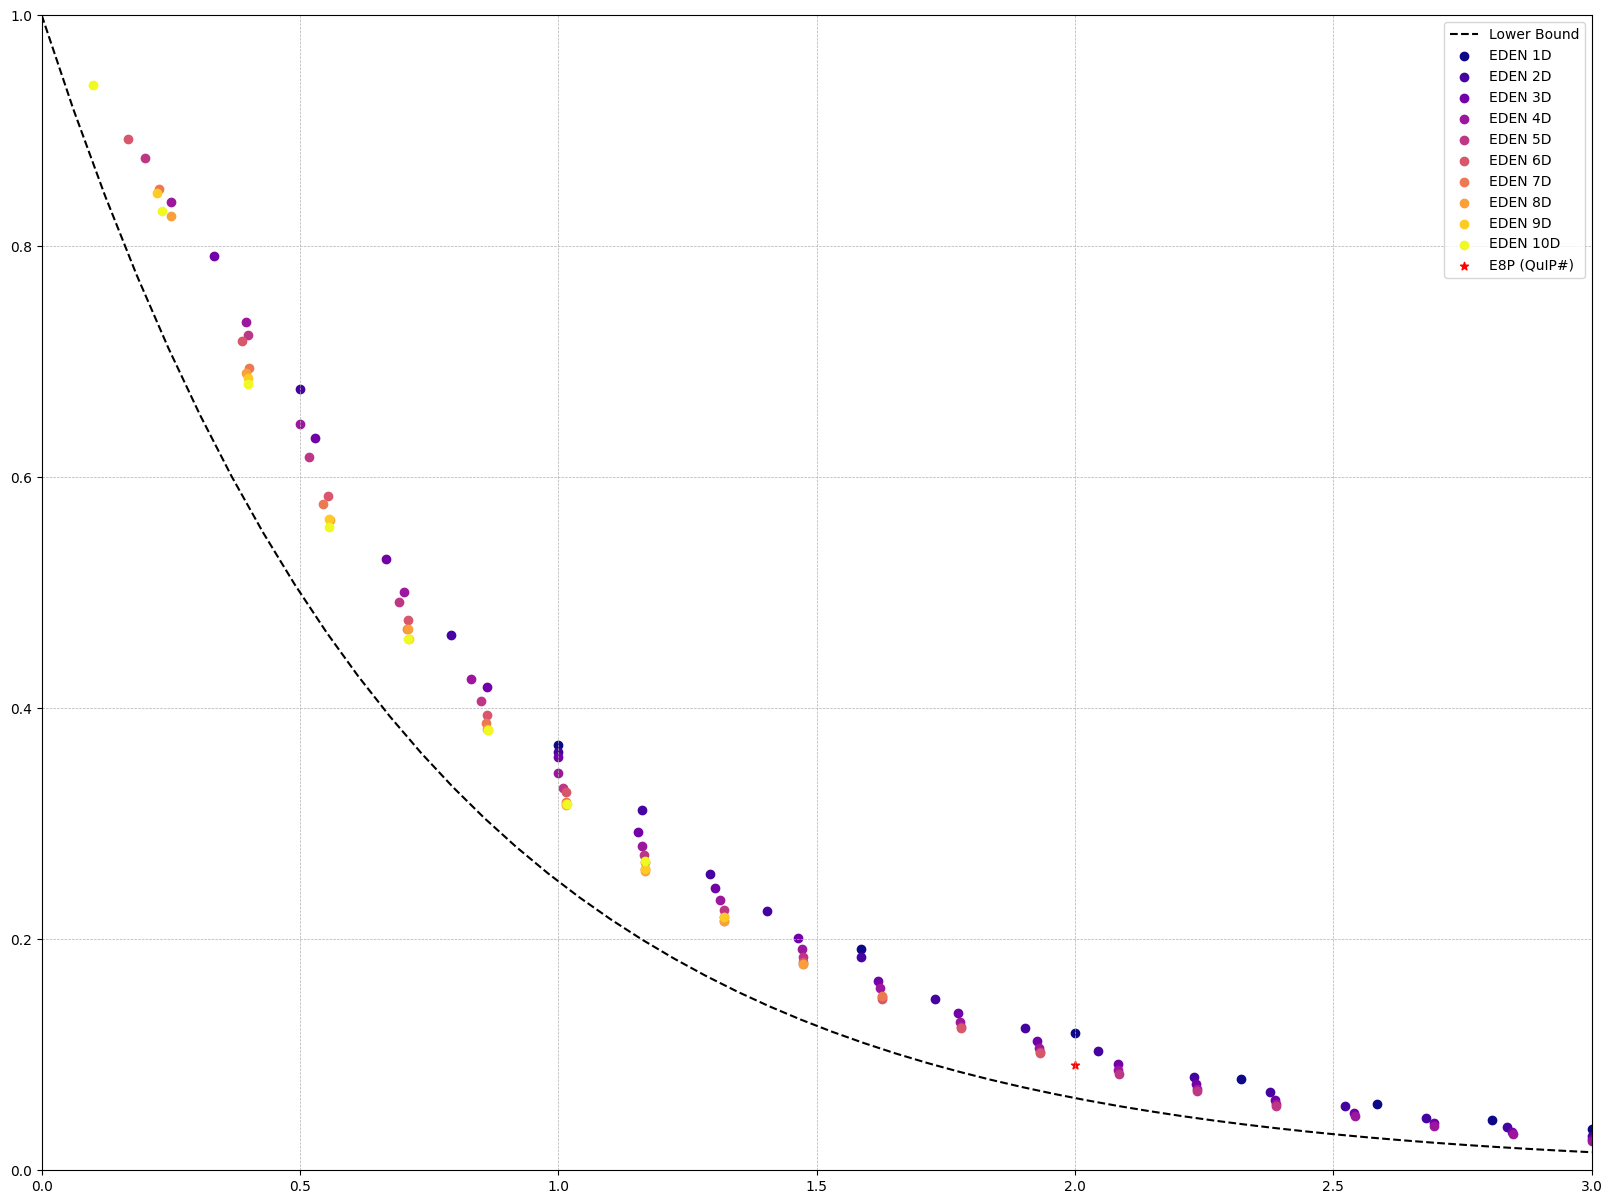

In [15]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
from matplotlib import colors

plt.figure(figsize=(20, 15))
plt.plot(np.linspace(0, 3), 4 ** (-np.linspace(0, 3)), label="Lower Bound", color="black", linestyle="--")

cmap = mpl.colormaps["plasma"]


# Plot EDEN_MEANS against log2(grid_size)/dim on a single plot with different dim as different lines
for pos, (dim, dimed_grids) in zip(np.linspace(0, 1, num=len(GRIDS)), sorted(GRIDS.items())):
    if len(dimed_grids) < 4:
        continue
    
    plt.scatter(
        [np.log2(grid_size)/dim for grid_size in sorted(dimed_grids.keys())],
        [EDEN_MEANS[dim][grid_size] for grid_size in sorted(dimed_grids.keys())],
        label=f"EDEN {dim}D",
        color=cmap(pos),
        marker="o" if grid_size * dim * 16 < 4096**2 / dim * np.log2(grid_size) else "*"
    )
    
plt.scatter(2, QUIP_SHARP_MEANS[2], color="red", label="E8P (QuIP#)", marker="*")
    
# plt.scatter([2, 3, 4], [QUIP_SHARP_MEANS[2], QUIP_SHARP_MEANS[3], QUIP_SHARP_MEANS[4]], label="QUIP Sharp")
    
# plt.yscale("log")
plt.xlim(0, 3)
plt.ylim(0, 1)
plt.legend()

# add grid
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    
